和Q学习的区别只在于target的计算方法不同

SARSA的target计算公式:
target = Q(next_state,next_action) * gamma + reward

Q学习的target计算公式:
target = max(Q(next_state)) * gamma + reward

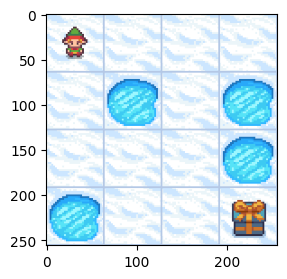

In [1]:
import gym
from matplotlib import pyplot as plt

#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        #is_slippery控制会不会滑
        env = gym.make('FrozenLake-v1',
                       render_mode='rgb_array',
                       is_slippery=False)

        super().__init__(env)
        self.env = env

    def reset(self):
        state, _ = self.env.reset()
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        #走一步扣一份,逼迫机器人尽快结束游戏
        if not over:
            reward = -1

        #掉坑扣100分
        if over and reward == 0:
            reward = -100

        return state, reward, over

    #打印游戏图像
    def show(self):
        
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [2]:
import numpy as np

#初始化Q表,定义了每个状态下每个动作的价值
Q = np.zeros((16, 4))

Q

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

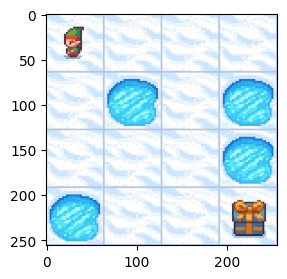

-199

In [5]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        action = Q[state].argmax()
        if random.random() < 0.1:
            action = env.action_space.sample()

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


play(True)[-1]

In [6]:
#数据池
class Pool:

    def __init__(self):
        self.pool = []

    def __len__(self):
        return len(self.pool)

    def __getitem__(self, i):
        return self.pool[i]

    #更新动作池
    def update(self):
        #每次更新不少于N条新数据
        old_len = len(self.pool)
        while len(pool) - old_len < 200:
            self.pool.extend(play()[0])

        #只保留最新的N条数据
        self.pool = self.pool[-1_0000:]

    #获取一批数据样本
    def sample(self):
        return random.choice(self.pool)


pool = Pool()
pool.update()

len(pool), pool[0]

(265, (0, 0, -1, 0, False))

In [5]:
#训练
def train():
    #共更新N轮数据
    for epoch in range(200):
        pool.update()

        #每次更新数据后,训练N次
        for i in range(200):

            #随机抽一条数据
            state, action, reward, next_state, over = pool.sample()

            #Q矩阵当前估计的state下action的价值
            value = Q[state, action]

            #求下一个动作,和Q学习唯一的区别点
            next_action = Q[next_state].argmax()

            #实际玩了之后得到的reward+下一个状态的价值*0.9
            target = reward + Q[next_state, next_action] * 0.9

            #value和target应该是相等的,说明Q矩阵的评估准确
            #如果有误差,则应该以target为准更新Q表,修正它的偏差
            #这就是TD误差,指评估值之间的偏差,以实际成分高的评估为准进行修正
            update = (target - value) * 0.02

            #更新Q表
            Q[state, action] += update

        if epoch % 100 == 0:
            print(epoch, len(pool), play()[-1])


train()

0 554 -116
100 10000 -4.0
200 10000 -6.0
300 10000 -6.0
400 10000 -5.0
500 10000 -5.0
600 10000 -105
700 10000 -4.0
800 10000 -4.0
900 10000 -5.0
1000 10000 -6.0
1100 10000 -5.0
1200 10000 -4.0
1300 10000 -4.0
1400 10000 -7.0
1500 10000 -5.0
1600 10000 -4.0
1700 10000 -5.0
1800 10000 -4.0
1900 10000 -4.0


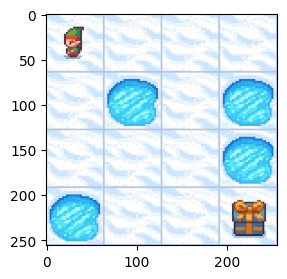

-199

In [7]:
play(True)[-1]